<a href="https://colab.research.google.com/github/HarryMusketeer/Machine-Learning-Project/blob/main/Copy_of_Capsule_Network_(CapsNet)_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsule Networks (CapsNet)
Link to paper: https://arxiv.org/pdf/1710.09829.pdf

In [ ]:
!nvidia-smi

Sat Aug 14 13:44:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.auto import tqdm
from collections import defaultdict

## Load MNIST
Training is performed on 28 x 28 MNIST images that have been shifted by up to 2 pixels in each direction with zero padding. No other data augmentation/deformation is used.

In [ ]:
INPUT_SIZE = (1, 28, 28)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(INPUT_SIZE[1:], padding=2), # Set output size to 28 x 28, up shift performed with padding.
    torchvision.transforms.ToTensor(), # Convert to tensor
])

The dataset has 60K and 10K images for training and testing respectively.

In [ ]:
trn_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transforms)
tst_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transforms)
print('Images for training: %d' % len(trn_dataset))
print('Images for testing: %d' % len(tst_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Images for training: 60000
Images for testing: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
BATCH_SIZE = 128 # Batch size not specified in the paper
trn_loader = torch.utils.data.DataLoader(trn_dataset, BATCH_SIZE, shuffle=True)
tst_loader = torch.utils.data.DataLoader(tst_dataset, BATCH_SIZE, shuffle=False)

## CapsNet architecture
![CapsNet architecture](https://i.imgur.com/4LsIheq.png)

### Conv1 layer
Conv1 has 256, 9 x 9 convolution kernels with a stride of 1 and ReLU activation. This layer converts pixel intensities to the activities of local feature detectors that are then used as inputs to the *primary* capsules.


In [ ]:
class Conv1(torch.nn.Module):  # Base class for all neural network modules
    def __init__(self, in_channels, out_channels=256, kernel_size=9):
        super().__init__()  # Changed from original
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv(x)  # Apply 256 9 x 9 convolutional layers
        x = self.activation(x)  # Apply ReLU
        return x

### Primary Capsules
The second layer (PrimaryCapsules) is a convolutional capsule layer with 32 channels of convolutional 8D capsules (*i*.*e*. each primary capsule contains 8 convolutional units with a 9 x 9 kernel and a stride of 2). Each primary capsule sees the outputs of all 256 x 81 Conv1 units whose receptive fields overlap with the location of the center of the capsule. In total PrimaryCapsules has [32 x 6 x 6] capsule outputs (each output is an 8D vector) and each capsule in the [6 x 6] grid is sharing their weights with each other. One can see PrimaryCapsules as a Convolution layer with Eq. 1 as its block non-linearity. Eq. 1:
\begin{equation*}
\mathbf{v}_j = \frac{||\mathbf{s}_j||^2}{1 + ||\mathbf{s}_j||^2} \frac{\mathbf{s}_j}{||\mathbf{s}_j||}
\end{equation*}

In [ ]:
class PrimaryCapsules(torch.nn.Module):
    def __init__(self, input_shape=(256, 20, 20), capsule_dim=8, out_channels=32, kernel_size=9, stride=2):
        super().__init__()
        self.input_shape = input_shape
        self.capsule_dim = capsule_dim
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = self.input_shape[0]

        self.conv = torch.nn.Conv2d(
            self.in_channels,
            self.out_channels * self.capsule_dim,
            self.kernel_size,
            self.stride
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(-1, x.size()[1], x.size()[2], self.out_channels, self.capsule_dim)
        return x

### Routing

In [ ]:
class Routing(torch.nn.Module):
    def __init__(self, caps_dim_before=8, caps_dim_after=16, n_capsules_before=(6 * 6 * 32), n_capsules_after=10):
        super().__init__()
        self.n_capsules_before = n_capsules_before
        self.n_capsules_after = n_capsules_after
        self.caps_dim_before = caps_dim_before
        self.caps_dim_after = caps_dim_after

        # Parameter initialization not specified in the paper
        n_in = self.n_capsules_before * self.caps_dim_before
        variance = 2 / (n_in)
        std = np.sqrt(variance)
        self.W = torch.nn.Parameter(
            torch.randn(
                self.n_capsules_before,
                self.n_capsules_after,
                self.caps_dim_after,
                self.caps_dim_before
            ) * std, requires_grad=True
        )

    # Equation (1)
    @staticmethod
    def squash(s):
        s_norm = torch.norm(s, p=2, dim=-1, keepdim=True)  # a.k.a. ||s_j|| in paper
        s_norm2 = torch.pow(s_norm, 2)  # a.k.a. ||s_j||^2 in paper
        v = (s_norm2 / (1.0 + s_norm2)) * (s / s_norm)
        return v

    # Equation (2)
    def affine(self, x):
        x = self.W @ x.unsqueeze(2).expand(-1, -1, 10, -1).unsqueeze(-1)  # @ means matrix multiplication
        return x.squeeze()

    # Equation (3)
    @staticmethod
    def softmax(b, dim=-1):
        exp = torch.exp(b)
        return exp / torch.sum(exp, dim, keepdim=True)

    # Procedure 1 - Routing algorithm
    def routing(self, u, r, l):
        b = Variable(torch.zeros(u.size()[0], l[0], l[1]), requires_grad=False).cuda()  # torch.Size([?, 1152, 10])

        for iteration in range(r):
            c = Routing.softmax(b)  # torch.Size([?, 1152, 10])
            s = (c.unsqueeze(-1).expand(-1, -1, -1, u.size()[-1]) * u).sum(1)  # torch.Size([?, 1152, 16])
            v = Routing.squash(s)  # torch.Size([?, 10, 16])
            b += (u * v.unsqueeze(1).expand(-1, l[0], -1, -1)).sum(-1)
        
        return v
    
    def forward(self, x, n_routing_iter):
        x = x.view((-1, self.n_capsules_before, self.caps_dim_before))
        x = self.affine(x)  # torch.Size([?, 1152, 10, 16])
        x = self.routing(x, n_routing_iter, (self.n_capsules_before, self.n_capsules_after))
        return x

The final Layer (DigitCaps) has one 16D capsule per digit class and each of these capsules receives input from all the capsules in the layer below.

We have routing only between two consecutive capsule layers (e.g. PrimaryCapsules and DigitCaps). Since Conv1 output is 1D, there is no orientation in its space to agree on. Therefore, no routing is used between Conv1 and PrimaryCapsules. All the routing logits ($b_{ij}$) are initialized to zero. Therefore, initially a capsule output ($u_{i}$) is sent to all parent capsules ($v_0...v_9$) with equal probability ($c_{ij}$).

### Norm

We are using the length of the instantiation vector to represent the probability that a capsule's entity exists. We would like the top-level capsule for digit class $k$ to have a long instantiation vector if and only if that digit is present in the image.

In [ ]:
class Norm(torch.nn.Module):
    def __init__(self):
        super(Norm, self).__init__()

    def forward(self, x):
        x = torch.norm(x, p=2, dim=-1)
        return x

### Decoder
During training, we mask out all but the activity vector of the correct digit capsule. Then we use this activity vector to reconstruct the input image. The output of the digit capsule is fed into a decoder consisting of 3 fully connected layers that model the pixel intensities.
![Decoder](https://i.imgur.com/wJqZSdi.png)

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, in_features, out_features, output_size=INPUT_SIZE):
        super().__init__()
        self.decoder = self.assemble_decoder(in_features, out_features)
        self.output_size = output_size

    def assemble_decoder(self, in_features, out_features):
        HIDDEN_LAYER_FEATURES = [512, 1024]
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, HIDDEN_LAYER_FEATURES[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[0], HIDDEN_LAYER_FEATURES[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[1], out_features),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x, y):
        x = x[np.arange(0, x.size()[0]), y.cpu().data.numpy(), :].cuda()
        x = self.decoder(x)
        x = x.view(*((-1,) + self.output_size))
        return x

### CapsNet
The architecture is shallow with only two convolutional layers and one fully connected layer.

In [ ]:
class CapsNet(torch.nn.Module):
    def __init__(self, input_shape=INPUT_SIZE, n_routing_iter=3, use_reconstruction=True):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_routing_iter = n_routing_iter
        self.use_reconstruction = use_reconstruction

        self.conv1 = Conv1(in_channels=input_shape[0], out_channels=256, kernel_size=9)
        self.primary_capsules = PrimaryCapsules(
            input_shape=(256, 20, 20),
            capsule_dim=8,
            out_channels=32,
            kernel_size=9,
            stride=2
        )
        self.routing = Routing(
            caps_dim_before=8,
            caps_dim_after=16,
            n_capsules_before=6 * 6 * 32,
            n_capsules_after=10
        )
        self.norm = Norm()

        if (self.use_reconstruction):
            self.decoder = Decoder(16, int(np.prod(input_shape)))
    
    def n_parameters(self):
        return np.sum([np.prod(x.size()) for x in self.parameters()])

    def forward(self, x, y=None):
        conv1 = self.conv1(x)
        primary_capsules = self.primary_capsules(conv1)
        digit_caps = self.routing(primary_capsules, self.n_routing_iter)
        scores = self.norm(digit_caps)

        if (self.use_reconstruction and y is not None):
            reconstruction = self.decoder(digit_caps, y).view((-1,) + self.input_shape)
            return scores, reconstruction
        
        return scores

### Define Loss Functions

#### Margin Loss
To allow for multiple digits, we use a separate margin loss, $L_k$ for each digit capsule, $k$:

$$L_k = T_k max(0, m^+-||v_k||)^2 + \lambda(1-T_k)max(0, ||v_k||-m^-)^2$$
where $T_k=1$ iff a digit of class $k$ is present and $m^+=0.9$ and $m^-=0.1$. The $\lambda$ down-weighting of the loss for absent digit classes stops the initial learning from shrinking the lengths of the activity vectors of all the digit capsules. We use $\lambda=0.5$. The total loss is simply the sum of the losses of all digit capsules.

In [ ]:
def to_categorical(y, num_classes):
    """
    1-hot encodes a tensor
    """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y

In [ ]:
class MarginLoss(torch.nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lamb=0.5):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lamb = lamb
    
    # Equation (4)
    def forward(self, scores, y):
        y = Variable(to_categorical(y, 10))
        
        Tc = y.float()
        loss_pos = torch.pow(torch.clamp(self.m_pos - scores, min=0), 2)
        loss_neg = torch.pow(torch.clamp(scores - self.m_neg, min=0), 2)
        loss = Tc * loss_pos + self.lamb * (1 - Tc) * loss_neg
        loss = loss.sum(-1)
        return loss.mean()

#### Reconstruction Loss
We use an additional reconstruction loss to encourage the digit capsules to encode the instantiation parameters of the input digit. We minimize the sum of squared differences between the outputs of the logistic units and the pixel intensities.

In [ ]:
class SumSquaredDifferencesLoss(torch.nn.Module):
    def __init__(self):
        super(SumSquaredDifferencesLoss, self).__init__()
    
    def forward(self, x_reconstruction, x):
        loss = torch.pow(x - x_reconstruction, 2).sum(-1).sum(-1)
        return loss.mean()

#### Total Loss
We scale down this reconstruction loss by $0.0005$ so that it does not dominate the margin loss during training.

In [ ]:
class CapsNetLoss(torch.nn.Module):
    def __init__(self, reconstruction_loss_scale=0.0005):
        super(CapsNetLoss, self).__init__()
        self.digit_existance_criterion = MarginLoss()
        self.digit_reconstruction_criterion = SumSquaredDifferencesLoss()
        self.reconstruction_loss_scale = reconstruction_loss_scale
    
    def forward(self, x, y, x_reconstruction, scores):
        margin_loss = self.digit_existance_criterion(y_pred.cuda(), y)
        reconstruction_loss = self.reconstruction_loss_scale *\
                              self.digit_reconstruction_criterion(x_reconstruction, x)
        loss = margin_loss + reconstruction_loss
        return loss, margin_loss, reconstruction_loss

## Train

### Initialize model

In [ ]:
model = CapsNet().cuda()
model

CapsNet(
  (conv1): Conv1(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (activation): ReLU()
  )
  (primary_capsules): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (routing): Routing()
  (norm): Norm()
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

CapsNet has 8.2M parameters and 6.8M parameters without the reconstruction subnetwork.

In [ ]:
print('Number of Parameters: %d' % model.n_parameters())

Number of Parameters: 8141840


In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
              ReLU-2          [-1, 256, 20, 20]               0
             Conv1-3          [-1, 256, 20, 20]               0
            Conv2d-4            [-1, 256, 6, 6]       5,308,672
   PrimaryCapsules-5          [-1, 6, 6, 32, 8]               0
           Routing-6               [-1, 10, 16]               0
              Norm-7                   [-1, 10]               0
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.49
Params size (MB): 20.33
Estimated Total Size (MB): 22.82
----------------------------------------------------------------


### Criterion

In [ ]:
criterion = CapsNetLoss()

### Optimizer
We use the Adam optimizer with its TensorFlow default parameters, including the exponentially decaying learning rate, to minimize the sum of the margin losses in Eq. 4.

In [ ]:
def exponential_decay(optimizer, learning_rate, global_step, decay_steps, decay_rate, staircase=False):
    if (staircase):
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step // decay_steps)
    else:
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step / decay_steps)
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = decayed_learning_rate
    
    return optimizer

In [ ]:
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-08
)

### Training

In [ ]:
def save_checkpoint(epoch, train_accuracy, test_accuracy, model, optimizer, path=None):
    if (path is None):
        path = 'checkpoint-%f-%04d.pth' % (test_accuracy, epoch)
    state = {
        'epoch': epoch,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)

In [ ]:
def show_example(model, x, y, x_reconstruction, y_pred):
    x = x.squeeze().cpu().data.numpy()
    y = y.cpu().data.numpy()
    x_reconstruction = x_reconstruction.squeeze().cpu().data.numpy()
    _, y_pred = torch.max(y_pred, -1)
    y_pred = y_pred.cpu().data.numpy()
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x, cmap='Greys')
    ax[0].set_title('Input: %d' % y)
    ax[1].imshow(x_reconstruction, cmap='Greys')
    ax[1].set_title('Output: %d' % y_pred)
    plt.show()

In [ ]:
def test(model, loader):
    metrics = defaultdict(lambda:list())
    for batch_id, (x, y) in tqdm(enumerate(loader), total=len(loader)):
        x = Variable(x).float().cuda()
        y = Variable(y).cuda()
        y_pred, x_reconstruction = model(x, y)
        _, y_pred = torch.max(y_pred, -1)
        metrics['accuracy'].append((y_pred == y).cpu().data.numpy())
    metrics['accuracy'] = np.concatenate(metrics['accuracy']).mean()
    return metrics

In [ ]:
global_epoch = 0
global_step = 0
best_tst_accuracy = 0.0
history = defaultdict(lambda:list())
COMPUTE_TRN_METRICS = False

Epoch 1 (1/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.036403
Reconstruction Loss: 0.022451
Loss: 0.058854
Train Accuracy: 0.000000
Test Accuracy: 0.974400
Example:


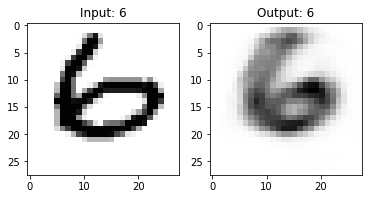

Epoch 2 (2/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.020385
Reconstruction Loss: 0.016152
Loss: 0.036537
Train Accuracy: 0.000000
Test Accuracy: 0.980600
Example:


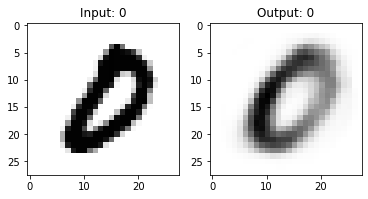

Epoch 3 (3/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.014241
Reconstruction Loss: 0.014650
Loss: 0.028891
Train Accuracy: 0.000000
Test Accuracy: 0.986900
Example:


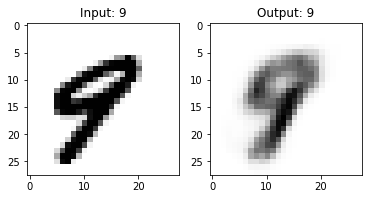

Epoch 4 (4/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.018498
Reconstruction Loss: 0.014998
Loss: 0.033496
Train Accuracy: 0.000000
Test Accuracy: 0.987500
Example:


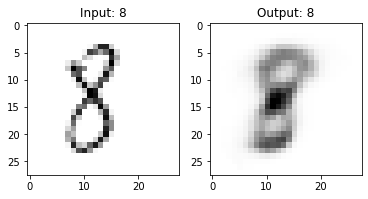

Epoch 5 (5/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.005115
Reconstruction Loss: 0.013686
Loss: 0.018802
Train Accuracy: 0.000000
Test Accuracy: 0.986900
Example:


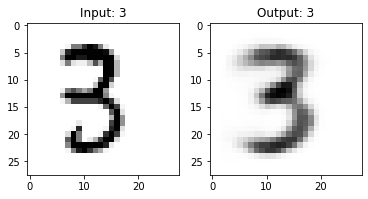

Epoch 6 (6/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.005112
Reconstruction Loss: 0.012153
Loss: 0.017265
Train Accuracy: 0.000000
Test Accuracy: 0.990300
Example:


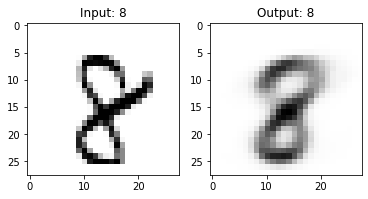

Epoch 7 (7/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.006611
Reconstruction Loss: 0.010936
Loss: 0.017547
Train Accuracy: 0.000000
Test Accuracy: 0.990900
Example:


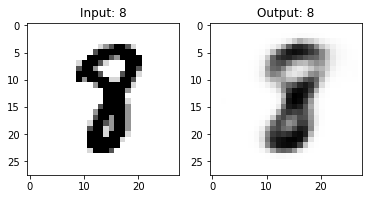

Epoch 8 (8/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.003061
Reconstruction Loss: 0.010657
Loss: 0.013717
Train Accuracy: 0.000000
Test Accuracy: 0.993200
Example:


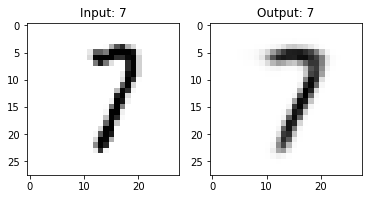

Epoch 9 (9/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.011549
Reconstruction Loss: 0.010024
Loss: 0.021573
Train Accuracy: 0.000000
Test Accuracy: 0.991100
Example:


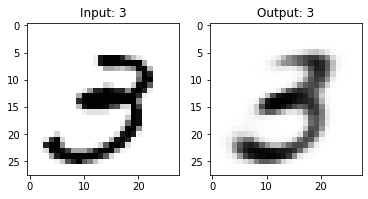

Epoch 10 (10/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.003907
Reconstruction Loss: 0.009976
Loss: 0.013882
Train Accuracy: 0.000000
Test Accuracy: 0.991800
Example:


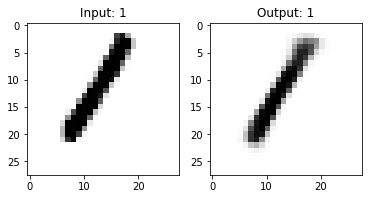

Epoch 11 (11/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.004562
Reconstruction Loss: 0.009952
Loss: 0.014513
Train Accuracy: 0.000000
Test Accuracy: 0.992600
Example:


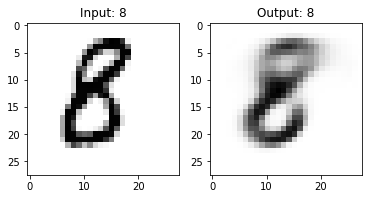

Epoch 12 (12/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.005100
Reconstruction Loss: 0.009619
Loss: 0.014719
Train Accuracy: 0.000000
Test Accuracy: 0.991800
Example:


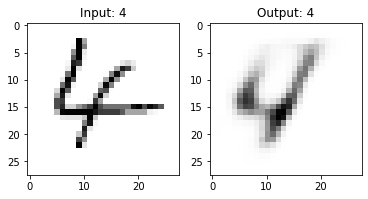

Epoch 13 (13/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.009237
Reconstruction Loss: 0.008622
Loss: 0.017859
Train Accuracy: 0.000000
Test Accuracy: 0.992800
Example:


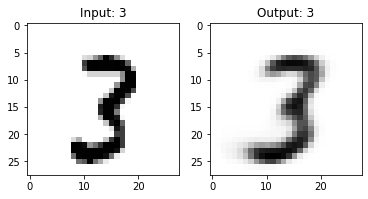

Epoch 14 (14/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.004121
Reconstruction Loss: 0.009593
Loss: 0.013713
Train Accuracy: 0.000000
Test Accuracy: 0.993400
Example:


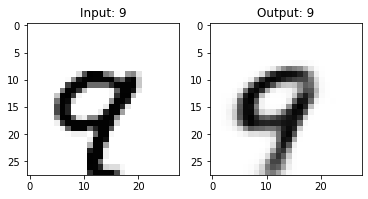

Epoch 15 (15/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.008704
Reconstruction Loss: 0.008170
Loss: 0.016874
Train Accuracy: 0.000000
Test Accuracy: 0.992800
Example:


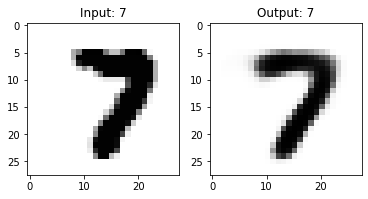

Epoch 16 (16/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.003016
Reconstruction Loss: 0.008716
Loss: 0.011732
Train Accuracy: 0.000000
Test Accuracy: 0.992300
Example:


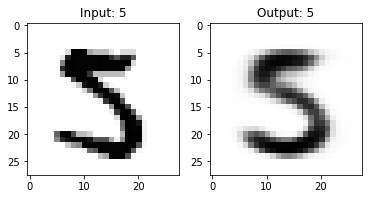

Epoch 17 (17/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001989
Reconstruction Loss: 0.008278
Loss: 0.010267
Train Accuracy: 0.000000
Test Accuracy: 0.992900
Example:


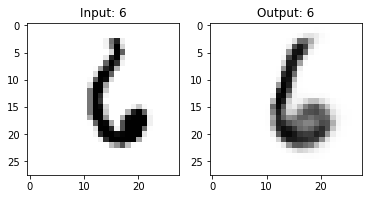

Epoch 18 (18/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.013181
Reconstruction Loss: 0.008504
Loss: 0.021685
Train Accuracy: 0.000000
Test Accuracy: 0.993800
Example:


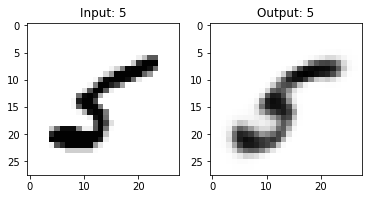

Epoch 19 (19/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001392
Reconstruction Loss: 0.008804
Loss: 0.010196
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


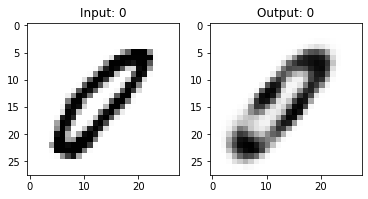

Epoch 20 (20/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002357
Reconstruction Loss: 0.008264
Loss: 0.010622
Train Accuracy: 0.000000
Test Accuracy: 0.993000
Example:


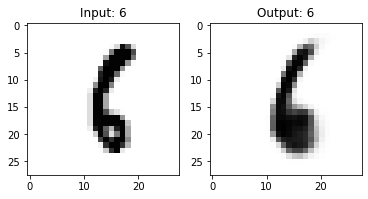

Epoch 21 (21/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.005332
Reconstruction Loss: 0.008174
Loss: 0.013506
Train Accuracy: 0.000000
Test Accuracy: 0.994500
Example:


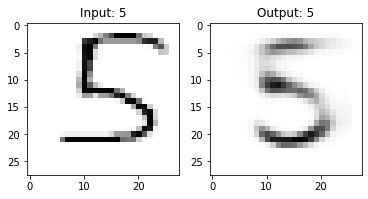

Epoch 22 (22/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002574
Reconstruction Loss: 0.008497
Loss: 0.011071
Train Accuracy: 0.000000
Test Accuracy: 0.993600
Example:


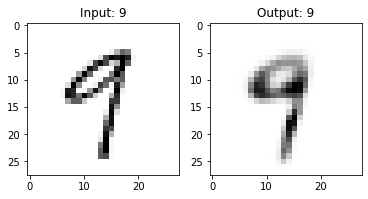

Epoch 23 (23/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.004637
Reconstruction Loss: 0.009080
Loss: 0.013717
Train Accuracy: 0.000000
Test Accuracy: 0.994300
Example:


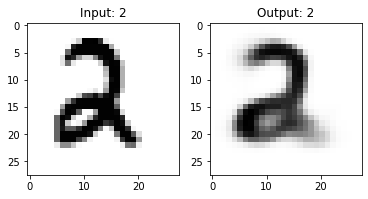

Epoch 24 (24/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.007626
Reconstruction Loss: 0.008507
Loss: 0.016133
Train Accuracy: 0.000000
Test Accuracy: 0.994500
Example:


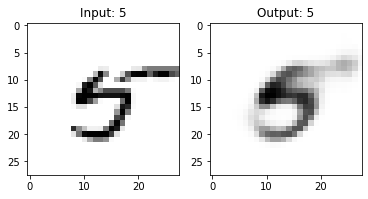

Epoch 25 (25/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000308
Reconstruction Loss: 0.007629
Loss: 0.007937
Train Accuracy: 0.000000
Test Accuracy: 0.994200
Example:


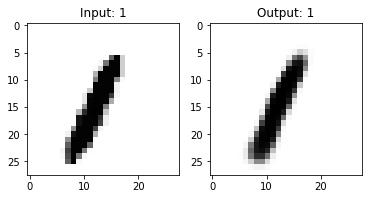

Epoch 26 (26/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001451
Reconstruction Loss: 0.008409
Loss: 0.009860
Train Accuracy: 0.000000
Test Accuracy: 0.993800
Example:


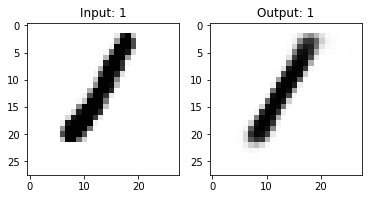

Epoch 27 (27/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001577
Reconstruction Loss: 0.007965
Loss: 0.009542
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


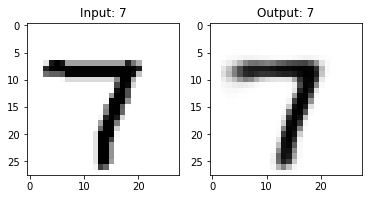

Epoch 28 (28/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001281
Reconstruction Loss: 0.007708
Loss: 0.008989
Train Accuracy: 0.000000
Test Accuracy: 0.994400
Example:


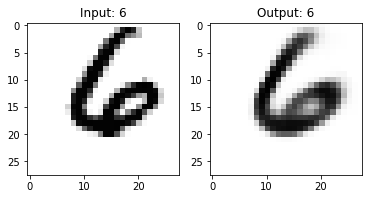

Epoch 29 (29/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001086
Reconstruction Loss: 0.008579
Loss: 0.009664
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


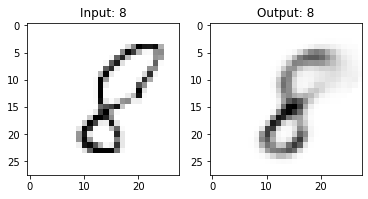

Epoch 30 (30/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000416
Reconstruction Loss: 0.007567
Loss: 0.007983
Train Accuracy: 0.000000
Test Accuracy: 0.994300
Example:


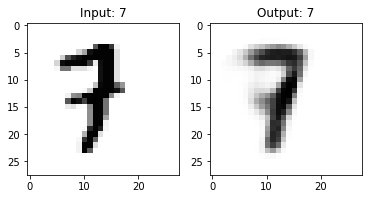

Epoch 31 (31/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000677
Reconstruction Loss: 0.007276
Loss: 0.007953
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


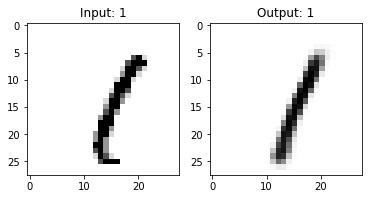

Epoch 32 (32/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002478
Reconstruction Loss: 0.008623
Loss: 0.011101
Train Accuracy: 0.000000
Test Accuracy: 0.994300
Example:


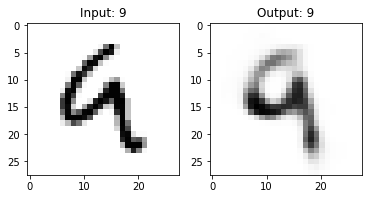

Epoch 33 (33/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001439
Reconstruction Loss: 0.008131
Loss: 0.009570
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


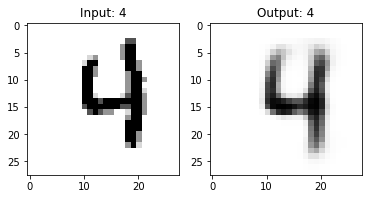

Epoch 34 (34/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001474
Reconstruction Loss: 0.008039
Loss: 0.009513
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


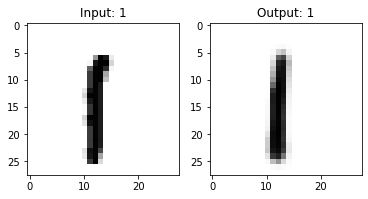

Epoch 35 (35/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000519
Reconstruction Loss: 0.007533
Loss: 0.008052
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


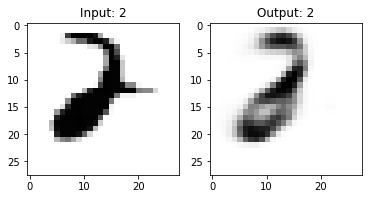

Epoch 36 (36/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000650
Reconstruction Loss: 0.008398
Loss: 0.009048
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


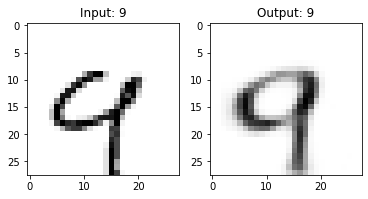

Epoch 37 (37/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000339
Reconstruction Loss: 0.008602
Loss: 0.008941
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


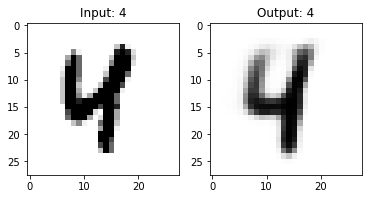

Epoch 38 (38/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002414
Reconstruction Loss: 0.008248
Loss: 0.010662
Train Accuracy: 0.000000
Test Accuracy: 0.995200
Example:


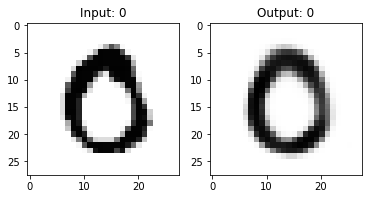

Epoch 39 (39/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000592
Reconstruction Loss: 0.007691
Loss: 0.008283
Train Accuracy: 0.000000
Test Accuracy: 0.994800
Example:


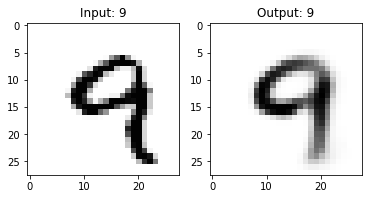

Epoch 40 (40/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000658
Reconstruction Loss: 0.007541
Loss: 0.008198
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


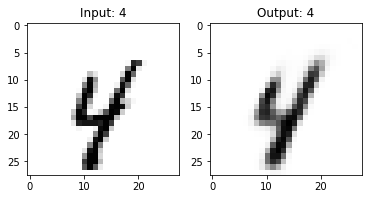

Epoch 41 (41/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000604
Reconstruction Loss: 0.007539
Loss: 0.008143
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


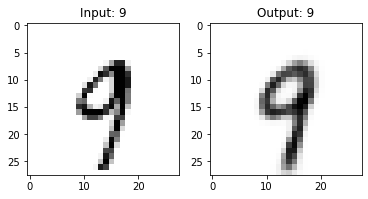

Epoch 42 (42/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000508
Reconstruction Loss: 0.007630
Loss: 0.008138
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


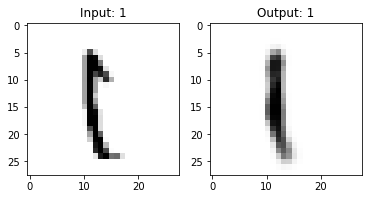

Epoch 43 (43/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000079
Reconstruction Loss: 0.006978
Loss: 0.007058
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


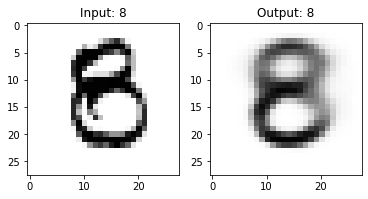

Epoch 44 (44/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000742
Reconstruction Loss: 0.007073
Loss: 0.007815
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


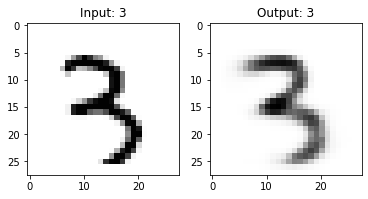

Epoch 45 (45/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000555
Reconstruction Loss: 0.007164
Loss: 0.007720
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


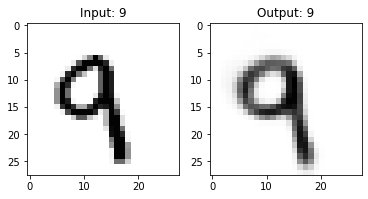

Epoch 46 (46/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001561
Reconstruction Loss: 0.007571
Loss: 0.009131
Train Accuracy: 0.000000
Test Accuracy: 0.995300
Example:


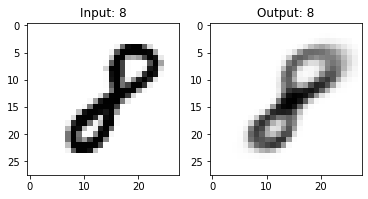

Epoch 47 (47/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002136
Reconstruction Loss: 0.007844
Loss: 0.009980
Train Accuracy: 0.000000
Test Accuracy: 0.995900
Example:


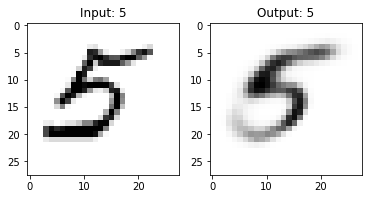

Epoch 48 (48/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000298
Reconstruction Loss: 0.008021
Loss: 0.008319
Train Accuracy: 0.000000
Test Accuracy: 0.994500
Example:


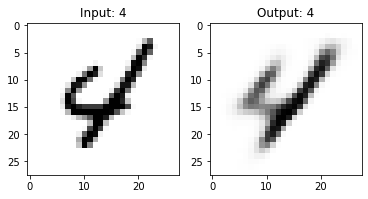

Epoch 49 (49/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001152
Reconstruction Loss: 0.007609
Loss: 0.008760
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


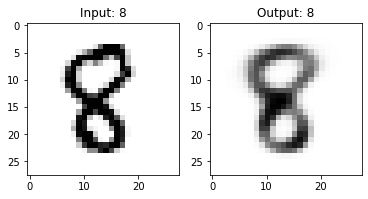

Epoch 50 (50/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.006179
Reconstruction Loss: 0.007652
Loss: 0.013831
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


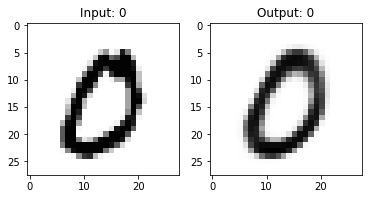

Epoch 51 (51/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001168
Reconstruction Loss: 0.007519
Loss: 0.008687
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


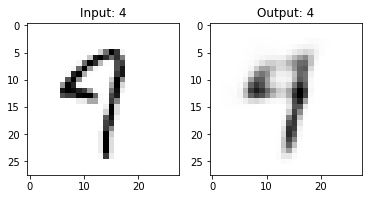

Epoch 52 (52/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000312
Reconstruction Loss: 0.007376
Loss: 0.007687
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


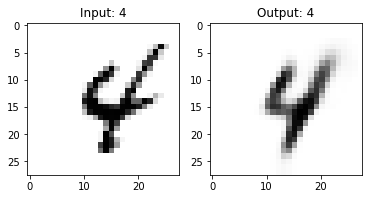

Epoch 53 (53/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001195
Reconstruction Loss: 0.007040
Loss: 0.008235
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


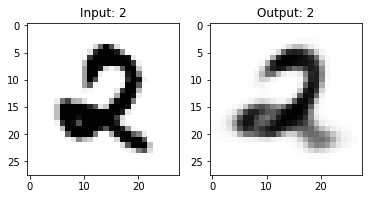

Epoch 54 (54/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000876
Reconstruction Loss: 0.007471
Loss: 0.008347
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


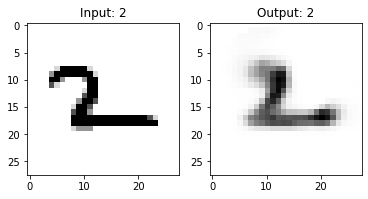

Epoch 55 (55/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000951
Reconstruction Loss: 0.007808
Loss: 0.008759
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


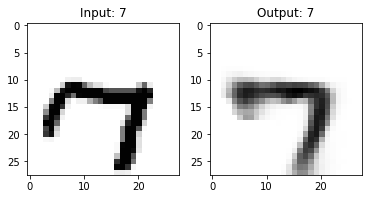

Epoch 56 (56/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001358
Reconstruction Loss: 0.007743
Loss: 0.009101
Train Accuracy: 0.000000
Test Accuracy: 0.995200
Example:


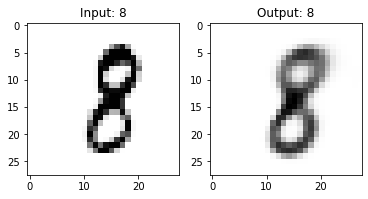

Epoch 57 (57/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001911
Reconstruction Loss: 0.007978
Loss: 0.009889
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


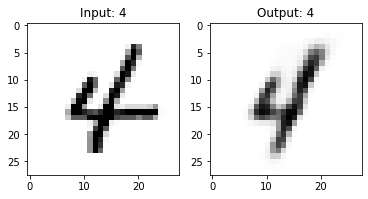

Epoch 58 (58/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001822
Reconstruction Loss: 0.008008
Loss: 0.009829
Train Accuracy: 0.000000
Test Accuracy: 0.995200
Example:


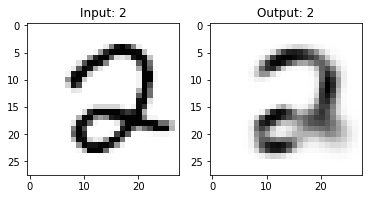

Epoch 59 (59/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000273
Reconstruction Loss: 0.007173
Loss: 0.007445
Train Accuracy: 0.000000
Test Accuracy: 0.994400
Example:


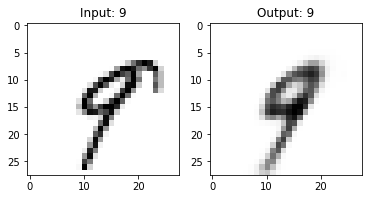

Epoch 60 (60/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000151
Reconstruction Loss: 0.006776
Loss: 0.006926
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


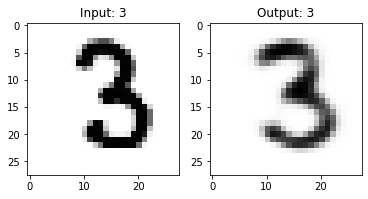

Epoch 61 (61/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000544
Reconstruction Loss: 0.006991
Loss: 0.007534
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


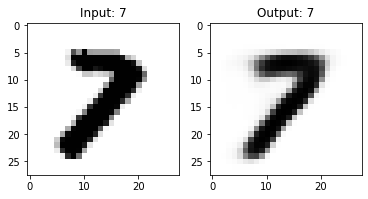

Epoch 62 (62/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000588
Reconstruction Loss: 0.007584
Loss: 0.008172
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


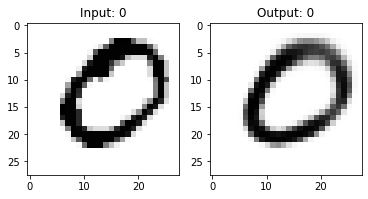

Epoch 63 (63/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.004020
Reconstruction Loss: 0.007855
Loss: 0.011874
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


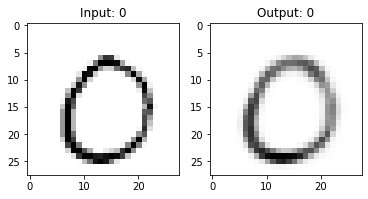

Epoch 64 (64/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000428
Reconstruction Loss: 0.008302
Loss: 0.008730
Train Accuracy: 0.000000
Test Accuracy: 0.995200
Example:


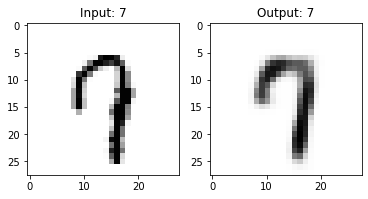

Epoch 65 (65/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000413
Reconstruction Loss: 0.007112
Loss: 0.007524
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


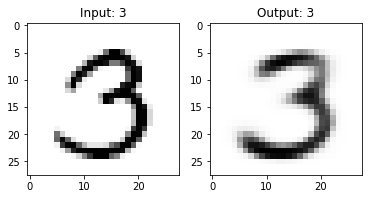

Epoch 66 (66/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000179
Reconstruction Loss: 0.007236
Loss: 0.007415
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


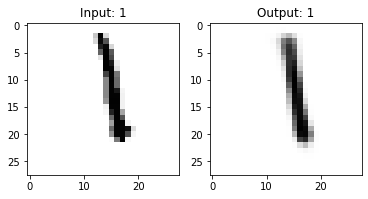

Epoch 67 (67/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000125
Reconstruction Loss: 0.007392
Loss: 0.007517
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


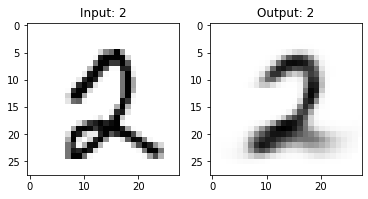

Epoch 68 (68/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001353
Reconstruction Loss: 0.007571
Loss: 0.008925
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


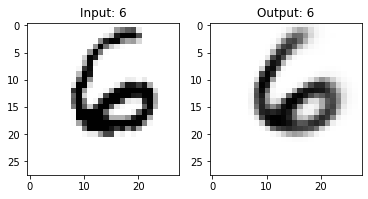

Epoch 69 (69/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001522
Reconstruction Loss: 0.007769
Loss: 0.009291
Train Accuracy: 0.000000
Test Accuracy: 0.995700
Example:


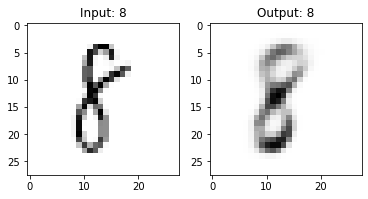

Epoch 70 (70/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000461
Reconstruction Loss: 0.007469
Loss: 0.007930
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


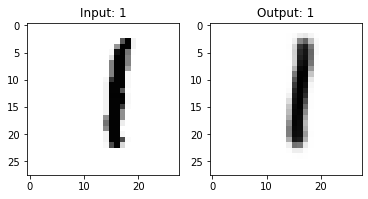

Epoch 71 (71/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.003197
Reconstruction Loss: 0.007979
Loss: 0.011177
Train Accuracy: 0.000000
Test Accuracy: 0.994200
Example:


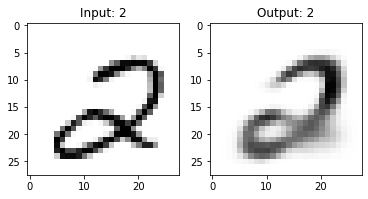

Epoch 72 (72/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000702
Reconstruction Loss: 0.007032
Loss: 0.007734
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


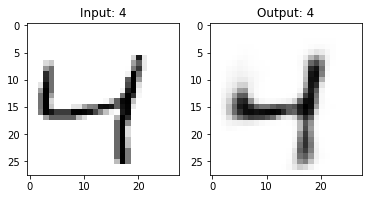

Epoch 73 (73/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001219
Reconstruction Loss: 0.008039
Loss: 0.009259
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


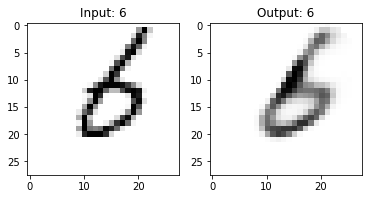

Epoch 74 (74/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002779
Reconstruction Loss: 0.007525
Loss: 0.010305
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


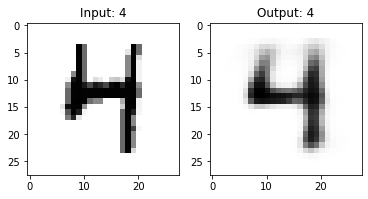

Epoch 75 (75/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000628
Reconstruction Loss: 0.007650
Loss: 0.008277
Train Accuracy: 0.000000
Test Accuracy: 0.995700
Example:


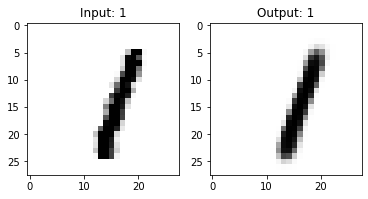

Epoch 76 (76/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001146
Reconstruction Loss: 0.007468
Loss: 0.008614
Train Accuracy: 0.000000
Test Accuracy: 0.994400
Example:


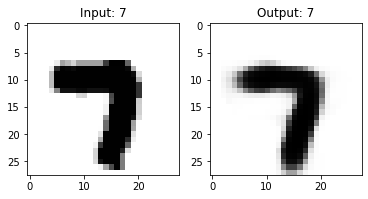

Epoch 77 (77/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001321
Reconstruction Loss: 0.006851
Loss: 0.008171
Train Accuracy: 0.000000
Test Accuracy: 0.994500
Example:


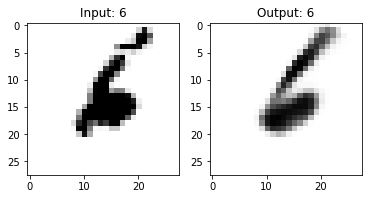

Epoch 78 (78/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000716
Reconstruction Loss: 0.007522
Loss: 0.008239
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


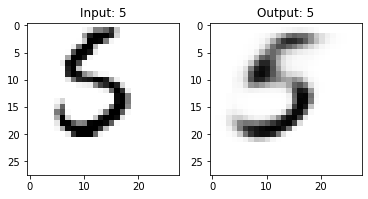

Epoch 79 (79/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.008347
Reconstruction Loss: 0.008089
Loss: 0.016436
Train Accuracy: 0.000000
Test Accuracy: 0.994100
Example:


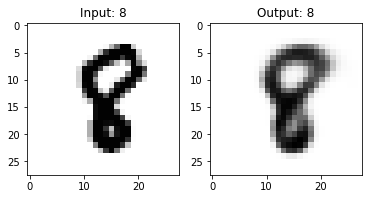

Epoch 80 (80/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000519
Reconstruction Loss: 0.007818
Loss: 0.008337
Train Accuracy: 0.000000
Test Accuracy: 0.995700
Example:


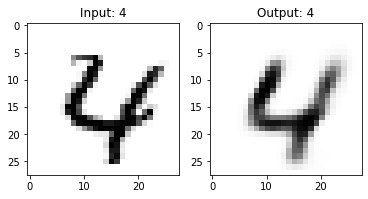

Epoch 81 (81/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000774
Reconstruction Loss: 0.008092
Loss: 0.008865
Train Accuracy: 0.000000
Test Accuracy: 0.995900
Example:


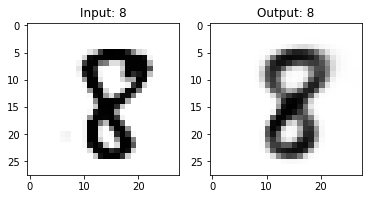

Epoch 82 (82/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001373
Reconstruction Loss: 0.007280
Loss: 0.008653
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


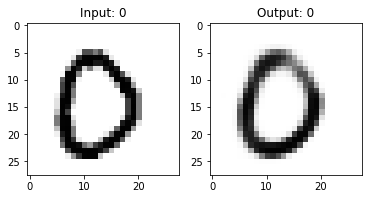

Epoch 83 (83/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000148
Reconstruction Loss: 0.007222
Loss: 0.007370
Train Accuracy: 0.000000
Test Accuracy: 0.995500
Example:


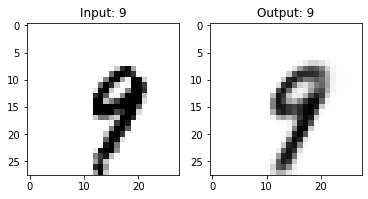

Epoch 84 (84/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.008662
Reconstruction Loss: 0.008287
Loss: 0.016948
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


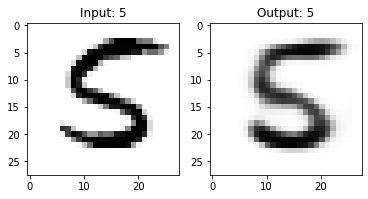

Epoch 85 (85/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000181
Reconstruction Loss: 0.007063
Loss: 0.007244
Train Accuracy: 0.000000
Test Accuracy: 0.995600
Example:


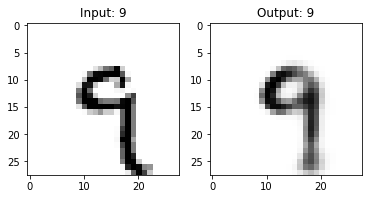

Epoch 86 (86/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000867
Reconstruction Loss: 0.007207
Loss: 0.008074
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


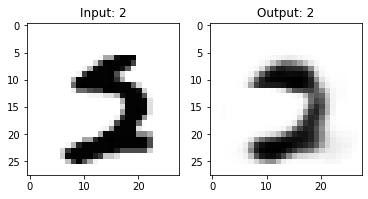

Epoch 87 (87/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000327
Reconstruction Loss: 0.006901
Loss: 0.007228
Train Accuracy: 0.000000
Test Accuracy: 0.995200
Example:


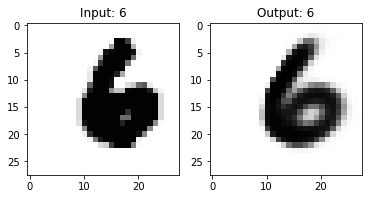

Epoch 88 (88/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.002450
Reconstruction Loss: 0.006622
Loss: 0.009072
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


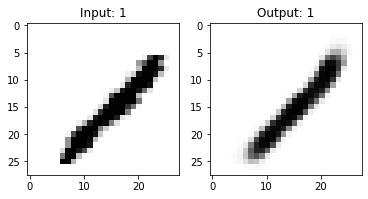

Epoch 89 (89/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000550
Reconstruction Loss: 0.007628
Loss: 0.008178
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


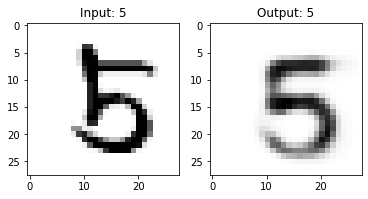

Epoch 90 (90/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000890
Reconstruction Loss: 0.007681
Loss: 0.008571
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


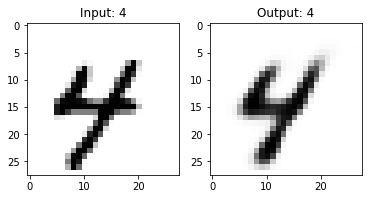

Epoch 91 (91/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000426
Reconstruction Loss: 0.007752
Loss: 0.008177
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


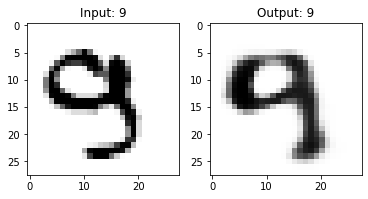

Epoch 92 (92/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000799
Reconstruction Loss: 0.007941
Loss: 0.008740
Train Accuracy: 0.000000
Test Accuracy: 0.995900
Example:


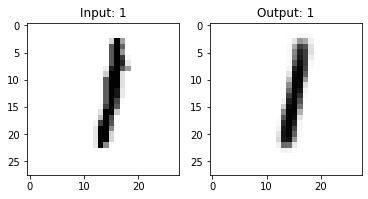

Epoch 93 (93/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000729
Reconstruction Loss: 0.007542
Loss: 0.008270
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


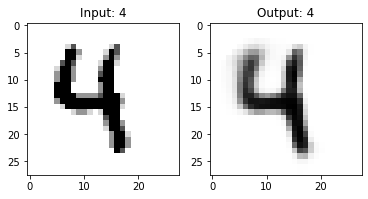

Epoch 94 (94/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000499
Reconstruction Loss: 0.007548
Loss: 0.008047
Train Accuracy: 0.000000
Test Accuracy: 0.994900
Example:


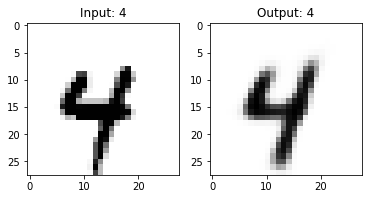

Epoch 95 (95/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000581
Reconstruction Loss: 0.007497
Loss: 0.008078
Train Accuracy: 0.000000
Test Accuracy: 0.995400
Example:


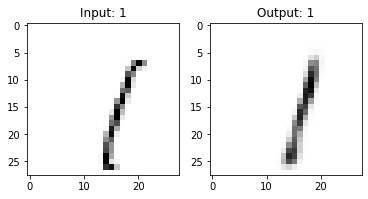

Epoch 96 (96/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000203
Reconstruction Loss: 0.006648
Loss: 0.006851
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


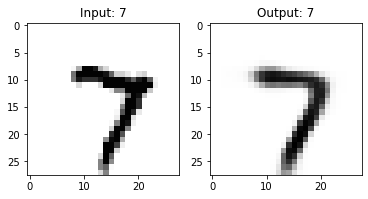

Epoch 97 (97/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000445
Reconstruction Loss: 0.007474
Loss: 0.007919
Train Accuracy: 0.000000
Test Accuracy: 0.995000
Example:


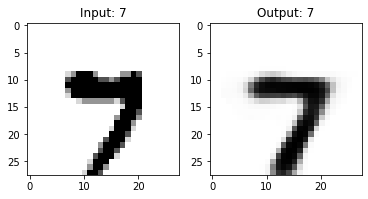

Epoch 98 (98/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000443
Reconstruction Loss: 0.007722
Loss: 0.008165
Train Accuracy: 0.000000
Test Accuracy: 0.995100
Example:


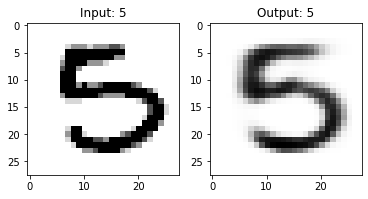

Epoch 99 (99/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000857
Reconstruction Loss: 0.007191
Loss: 0.008049
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


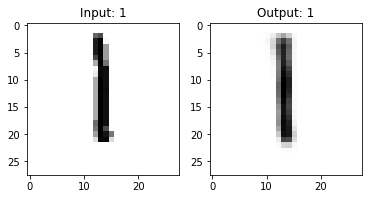

Epoch 100 (100/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000208
Reconstruction Loss: 0.007648
Loss: 0.007856
Train Accuracy: 0.000000
Test Accuracy: 0.994800
Example:


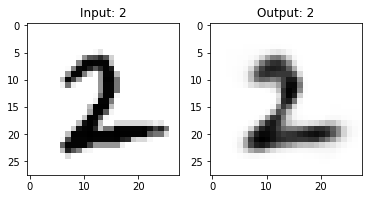

Epoch 101 (101/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000220
Reconstruction Loss: 0.006099
Loss: 0.006319
Train Accuracy: 0.000000
Test Accuracy: 0.995800
Example:


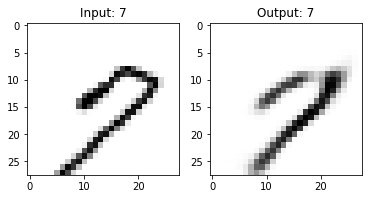

Epoch 102 (102/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000450
Reconstruction Loss: 0.007729
Loss: 0.008178
Train Accuracy: 0.000000
Test Accuracy: 0.995600
Example:


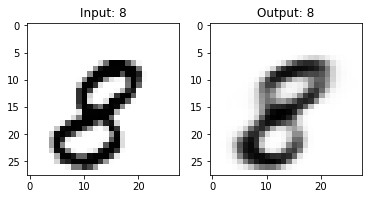

Epoch 103 (103/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000518
Reconstruction Loss: 0.007335
Loss: 0.007853
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


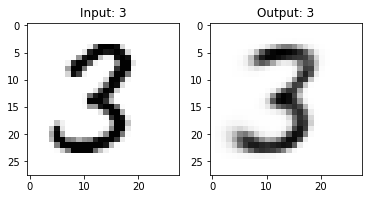

Epoch 104 (104/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.001735
Reconstruction Loss: 0.007260
Loss: 0.008995
Train Accuracy: 0.000000
Test Accuracy: 0.994700
Example:


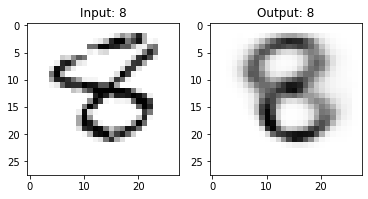

Epoch 105 (105/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000242
Reconstruction Loss: 0.006807
Loss: 0.007049
Train Accuracy: 0.000000
Test Accuracy: 0.994800
Example:


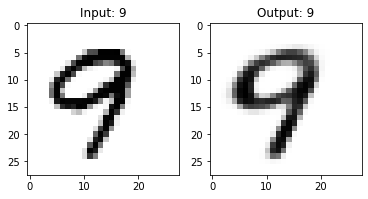

Epoch 106 (106/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000680
Reconstruction Loss: 0.008170
Loss: 0.008851
Train Accuracy: 0.000000
Test Accuracy: 0.994500
Example:


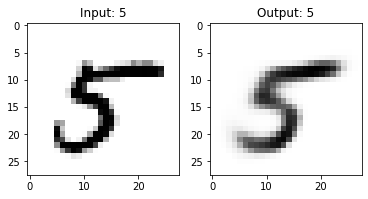

Epoch 107 (107/500):


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Margin Loss: 0.000750
Reconstruction Loss: 0.006079
Loss: 0.006829
Train Accuracy: 0.000000
Test Accuracy: 0.994600
Example:


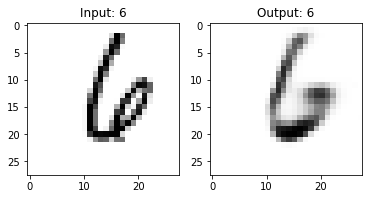

Epoch 108 (108/500):


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
n_epochs = 500 # Number of epochs not specified in the paper
for epoch in range(n_epochs):
    print('Epoch %d (%d/%d):' % (global_epoch + 1, epoch + 1, n_epochs))
    
    for batch_id, (x, y) in tqdm(enumerate(trn_loader), total=len(trn_loader)):
        optimizer = exponential_decay(optimizer, LEARNING_RATE, global_epoch, 1, 0.90) # Configurations not specified in the paper
        
        x = Variable(x).float().cuda()
        y = Variable(y).cuda()
        
        y_pred, x_reconstruction = model(x, y)
        loss, margin_loss, reconstruction_loss = criterion(x, y, x_reconstruction, y_pred.cuda())
        
        history['margin_loss'].append(margin_loss.cpu().data.numpy())
        history['reconstruction_loss'].append(reconstruction_loss.cpu().data.numpy())
        history['loss'].append(loss.cpu().data.numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1

    trn_metrics = test(model, trn_loader) if COMPUTE_TRN_METRICS else None
    tst_metrics = test(model, tst_loader)
    
    print('Margin Loss: %f' % history['margin_loss'][-1])
    print('Reconstruction Loss: %f' % history['reconstruction_loss'][-1])
    print('Loss: %f' % history['loss'][-1])
    print('Train Accuracy: %f' % (trn_metrics['accuracy'] if COMPUTE_TRN_METRICS else 0.0))
    print('Test Accuracy: %f' % tst_metrics['accuracy'])
    
    print('Example:')
    idx = np.random.randint(0, len(x))
    show_example(model, x[idx], y[idx], x_reconstruction[idx], y_pred[idx])
    
    if (tst_metrics['accuracy'] >= best_tst_accuracy):
        best_tst_accuracy = tst_metrics['accuracy']
        save_checkpoint(
            global_epoch + 1,
            trn_metrics['accuracy'] if COMPUTE_TRN_METRICS else 0.0,
            tst_metrics['accuracy'],
            model,
            optimizer,
            path='/content/cp.pth'
        )
    global_epoch += 1

## Loss Curve

In [ ]:
def compute_avg_curve(y, n_points_avg):
    avg_kernel = np.ones((n_points_avg,)) / n_points_avg
    rolling_mean = np.convolve(y, avg_kernel, mode='valid')
    return rolling_mean

In [ ]:
n_points_avg = 10
n_points_plot = 1000
plt.figure(figsize=(20, 10))

curve = np.asarray(history['loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-g')

curve = np.asarray(history['margin_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-b')

curve = np.asarray(history['reconstruction_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-r')

plt.legend(['Total Loss', 'Margin Loss', 'Reconstruction Loss'])
plt.show()